# Laboratorio 5: Clustering

Integrantes: **Tomás Vallejo Cerda** \ **Juan Pablo Bustamante** Sección 1

## Instrucciones


1. Trabajen en equipos de dos personas. Salvo excepciones, no se corregirá entregas con menos de dos integrantes.

2. Modifiquen este archivo `.ipynb` agregando sus respuestas donde corresponda.

3. Cuando finalicen el laboratorio, **generen un archivo HTML** usando jupyter y súbanlo a U-Cursos. El laboratorio debe ser entregado sólo por 1 integrante. Si se entrega por más de un integrante, se revisará cualquiera de éstos.

Para este lab trabajaremos con un dataset de texto sobre distintas noticias. Luego de procesar el texto, se realizará clustering sobre estos datos.Para este lab trabajaremos con un dataset de texto sobre  noticias de distintos temas (espacio, hockey, y computación gráfica). Luego de procesar el texto, se realizará clustering sobre estos datos.

In [2]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Solo algunas categorías
categories = ['sci.space', 'rec.sport.hockey', 'comp.graphics']

newsgroups = fetch_20newsgroups(subset='train', categories=categories, remove=('headers', 'footers', 'quotes'))

texts = newsgroups.data

# TF-IDF: consideramos la cantidad de veces que aparece c/palabra y que tan
# rara es (teorema de Shannon)
vectorizer_tfidf = TfidfVectorizer(stop_words='english')
X_vec = vectorizer_tfidf.fit_transform(texts).toarray()
X = pd.DataFrame(X_vec, columns=vectorizer_tfidf.get_feature_names_out())
X

KeyboardInterrupt: 

Obtuvimos un DataFrame donde cada columna representa una palabra, y su valor representa su importancia en el texto.

Hay una columna por cada posible palabra, por lo que muchos valores son 0 (matriz sparse)

## Visualizar los datos

### Pregunta 1

Nuestra matriz datos es muy dispersa (mayoría de valores en 0). Aplique PCA sobre los datos para reducirlos a solo 100 dimensiones. Visualice las primeras 2 dimensiones de los datos mediante un scatterplot.
Responda brevemente:

1. ¿Cuantos clusters cree que hay?
2. ¿Qué algoritmo de clustering podría funcionar mejor?

In [3]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reducir a 100 dimensiones
pca = PCA(n_components=100, random_state=42) #fijamos semilla
X_pca = pca.fit_transform(X)

# Graficar las primeras 2 dimensiones
plt.figure(figsize=(7,5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=10, alpha=0.6)
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.title('Visualización de los datos reducidos (PCA - 2 dimensiones)')
plt.show()


NameError: name 'X' is not defined

>**Respuesta:**

1) Al observar la proyección PCA, se distinguen aproximadamente tres zonas principales de densidad, lo que sugiere la existencia de tres posibles clusters. Esto resulta coherente con lo esperado teóricamente, ya que el dataset contiene tres temáticas distintas
Sin embargo, las fronteras entre grupos no son totalmente definidas, por lo que esta estimación debe confirmarse mediante un método cuantitativo, como el método del codo visto en clases.

2) Dado que la forma de los datos proyectados es relativamente continua y con zonas de alta densidad, un algoritmo como K-Means podría funcionar bien para obtener una primera segmentación simple y eficiente.
No obstante, si se quisiera capturar mejor las áreas más densas y ramificadas, también sería razonable probar DBSCAN, ya que como sabemos este algoritmo detecta agrupaciones de alta densidad y maneja mejor los puntos dispersos.

**Nota**: Desde ahora use `X_pca` a menos que se indique lo contrario

## K-Means

El algoritmo $K$-Means divide los puntos en $K$ (definido por el usuario) grupos disjuntos $\{\mathcal{C}_1, \dots, \mathcal{C}_K\}$ minimizando la varianza intra-cluster. El criterio minimizado $G$ se denomina *inercia*:

$$
G_X(\mathcal{C}_1, \dots, \mathcal{C}_K) = \sum_{k=1}^K \sum_{i \in \mathcal{C}_k}\| \mathbf{x}_i - \mu_k \|^2_2
$$

donde $\mu_k \in \mathbb{R}^d$ son los centroides de las $K$ clases ($|\mathcal{C}_k|$ es el número de puntos en cada clase):

$$
\mu_k = \frac{1}{|\mathcal{C}_k|} \sum_{i \in \mathcal{C}_k} \mathbf{x}_i, \quad \forall k \in [K]
$$

y donde la $i$-ésima observación pertenece a la clase cuyo centroide es más cercano, es decir, $i \in \mathcal{C}_j$ si y solo si:

$$
j = \argmin_{k \in [K]} \| \mathbf{x}_i - \mu_k \|_2 = \argmin_{k \in [K]} \| \mathbf{x}_i - \mu_k \|_2^2
$$

**Nota**: en caso de empates, se resuelven aleatoriamente si es necesario.

El agrupamiento se aprende alternando iterativamente los siguientes dos pasos:

1. Un paso de asignación donde, dados los $(\mu_k)_{k=1,\dots,K}$, determinamos la etiqueta de cada punto.
2. Un paso de actualización de centroides donde, dadas las etiquetas, calculamos los centros de los clusters.

El algoritmo se detiene cuando la inercia deja de disminuir significativamente (nota: incluso sin un criterio de parada, $K$-Means terminará en un número finito de pasos; ver Banerjee et al., 2005).

La inercia es un criterio no convexo, por lo que la solución depende de la inicialización. Por eso, el algoritmo suele ejecutarse múltiples veces con diferentes inicializaciones, y se conserva la solución con la menor inercia.

### Pregunta 2

Cuando usamos K-Means debemos definir previamente el número de clusters que queremos generar. Teniendo en cuenta estos datos, implemente el método del codo, calculando el sse para el rango de 1 a 10 clusters. ¿Combinando este método y la propia intuición, cuántos clusters propone usar para este dataset? Escoja dos opciones y justifique su elección.

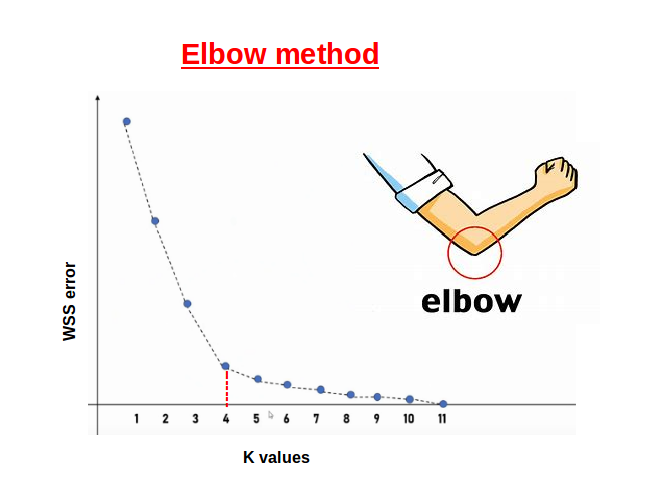

In [ ]:
from sklearn.cluster import KMeans

# Calcular la inercia (SSE) para K de 1 a 10
sse = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    sse.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(7,5))
plt.plot(K_range, sse, 'o-', color='steelblue')
plt.xlabel('Número de clusters (K)')
plt.ylabel('Inercia (SSE)')
plt.title('Método del codo (K-Means)')
plt.grid(True)
plt.xticks(K_range)
plt.show()


> **Respuesta:**

Al analizar el gráfico del método del codo, se observa que la inercia disminuye de forma pronunciada hasta **K = 3**, tras lo cual la curva comienza a aplanarse.  
Esto nos sugiere que **K = 3** es un punto óptimo donde se logra un buen equilibrio entre complejidad del modelo y reducción de la inercia.  

Como segunda opción, **K = 4** también podría considerarse razonable, ya que podría capturar subdivisiones adicionales visibles en la proyección PCA, especialmente en las zonas más ramificadas.  

**Propuestas:**  
- **Opción 1:** K = 3 → mejor equilibrio según el codo y coherente con la visualización PCA.  
- **Opción 2:** K = 4 → posible refinamiento en zonas con mayor densidad o ramificación.  

### Pregunta 3

 Entrene KMeans con el valor de $k$ elegido y genere un gráfico con la representación visual de los clusters (usando los datos reducidos).

In [ ]:
# Entrenar K-Means con K = 3
kmeans_3 = KMeans(n_clusters=3, random_state=42)
labels_3 = kmeans_3.fit_predict(X_pca)

plt.figure(figsize=(7,5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_3, cmap='viridis', s=10, alpha=0.7)
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.title('Clusters encontrados con K-Means (K=3)')
plt.show()

# Entrenar K-Means con K = 4
kmeans_4 = KMeans(n_clusters=4, random_state=42)
labels_4 = kmeans_4.fit_predict(X_pca)

plt.figure(figsize=(7,5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_4, cmap='plasma', s=10, alpha=0.7)
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.title('Clusters encontrados con K-Means (K=4)')
plt.show()

## Clustering Jerárquico

### Pregunta 4

Usando un sample de los datos, ejecute cada uno de los 4 métodos de clustering jerárquico: complete, single, average y ward, utilizando la metrica de distancia por defecto y visualice los dendrogramas formados. Adjunte el código necesario. No necesita generar los 4 dendrogramas en el mismo gráfico, pueden ser gráficos separados (individuales).

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

X_sample = pd.DataFrame(X_pca).sample(50, random_state=0) # utilice solo un sample de los datos

complete = linkage(X_sample, method="complete")    # Vista en clase como MAX
single = linkage(X_sample, method="single")        # Vista en clase como MIN
average = linkage(X_sample, method="average")
ward = linkage(X_sample, method="ward")

In [ ]:
# Calcular las uniones (linkages) con los 4 métodos
complete = linkage(X_sample, method="complete")    # MAX
single = linkage(X_sample, method="single")        # MIN
average = linkage(X_sample, method="average")
ward = linkage(X_sample, method="ward")

# Graficar los dendrogramas individualmente
plt.figure(figsize=(10, 5))
dendrogram(complete)
plt.title("Dendrograma - Método Complete (MAX)")
plt.xlabel("Observaciones")
plt.ylabel("Distancia")
plt.show()

plt.figure(figsize=(10, 5))
dendrogram(single)
plt.title("Dendrograma - Método Single (MIN)")
plt.xlabel("Observaciones")
plt.ylabel("Distancia")
plt.show()

plt.figure(figsize=(10, 5))
dendrogram(average)
plt.title("Dendrograma - Método Average")
plt.xlabel("Observaciones")
plt.ylabel("Distancia")
plt.show()

plt.figure(figsize=(10, 5))
dendrogram(ward)
plt.title("Dendrograma - Método Ward")
plt.xlabel("Observaciones")
plt.ylabel("Distancia")
plt.show()


### Pregunta 5

Vuelva a ejecutar el dendograma para el método `ward`, pero con el conjunto X completo (con PCA). ¿"Visualmente" cuántos clusters propone usar? ¿A qué altura recomendaría cortar el árbol?

In [ ]:
# Aplicar método Ward al conjunto completo reducido con PCA
ward_full = linkage(X_pca, method="ward")

# Visualizar dendrograma
plt.figure(figsize=(12, 6))
dendrogram(ward_full, truncate_mode='level', p=5)
plt.title("Dendrograma - Método Ward (X_pca completo)")
plt.xlabel("Observaciones o clusters")
plt.ylabel("Distancia")
plt.show()

> **Respuesta:**

Al observar el dendrograma obtenido con el método Ward, se distinguen aproximadamente tres grandes grupos antes de una altura cercana a 3.0, tras lo cual los clusters comienzan a fusionarse rápidamente.
Por lo tanto, visual y estructuralmente el dataset podría dividirse en tres clusters principales, lo que resulta coherente con los patrones observados previamente mediante PCA y el método del codo.
Se recomienda cortar el árbol a una altura aproximada de 3.0 (entre 2.8 y 3.2), donde las tres ramas principales se separan con mayor claridad.


### Pregunta 6

 Implemente el código para asignar clusters a los datos siguiendo lo que usted la áltura de corte que propuso en la pregunta anterior. Señale cuántos clusters se generan. Luego, usando el dataset con dimensiones reducidas generado con PCA, grafique los datos y píntelos con su asignacion de clusters.

In [ ]:
from scipy.cluster.hierarchy import fcluster
import numpy as np

# Definir la altura de corte
corte = 3.0

# Asignar etiquetas de cluster según la altura de corte
ward_labels = fcluster(ward_full, t=corte, criterion='distance')

# Mostrar cuántos clusters se generaron
n_clusters = len(np.unique(ward_labels))
print(f"Se generaron {n_clusters} clusters con un corte en altura = {corte}")

# Graficar los datos reducidos con PCA coloreados por los clusters jerárquicos
plt.figure(figsize=(7,5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=ward_labels, cmap='tab10', s=10, alpha=0.7)
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.title(f'Clusters jerárquicos (Ward) con corte a altura = {corte}')
plt.show()

## DBSCAN

Ahora probaremos hacer el clustering con el método DBSCAN.


### Pregunta 7

Explique el funcionamiento general del método de DBSCAN e indique que rol juegan los parámetros min_samples y eps.

>**Respuesta:**

Como lo vimpos en clase el DBSCAN es un método de clustering basado en la densidad de los puntos.  
En lugar de asumir una forma o cantidad fija de clusters, agrupa puntos que están cerca unos de otros en zonas densas, y marca como ruido aquellos que quedan aislados.

Los parámetros principales son:
- **eps:** define la distancia máxima que puede haber entre dos puntos para considerarse vecinos.
- **min_samples:** indica el mínimo número de puntos vecinos necesarios para que un punto se considere parte de una zona densa (y pueda formar un cluster).



In [ ]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

k = 5  # usado como min_samples en DBSCAN
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_pca)
distances, _ = neighbors_fit.kneighbors(X_pca)
k_distances = np.sort(distances[:, k-1]) # Ordenar las distancias al k-ésimo vecino

plt.plot(k_distances)
# TODO: elija el valor de y
plt.axhline(y=0, color='r')
plt.ylabel(f'Distancia al {k}-ésimo vecino')
plt.xlabel('Puntos ordenados')
plt.title('Gráfico de codo para estimar eps en DBSCAN')
plt.grid(True)
plt.show()

Ejecute la siguiente celda que implementa el método de DBSCAN:

In [ ]:
from sklearn.cluster import DBSCAN

#Pauta
eps = 0.54
min_samples = 5

dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(X_pca)

print(len(np.unique(dbscan.labels_) - 1), "clusters")

scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=dbscan.labels_)
plt.title(f"DBSCAN: eps={eps}, min_samples={min_samples}")
plt.show()

¿Es una buena idea usar DBSCAN en este caso? Justifique

>**Respuesta:**

En este caso, DBSCAN no resulta una buena opción.
El gráfico muestra que el algoritmo agrupa casi todos los puntos dentro de un único gran cluster, sin separar adecuadamente las distintas zonas de densidad observadas en PCA.
Esto ocurre probablemnete porque los datos presentan una estructura continua y densa, sin regiones claramente separadas, lo que dificulta que DBSCAN identifique fronteras entre clusters.
En consecuencia, métodos como K-Means o Ward funcionan mejor para este tipo de distribución, ya que permiten dividir la estructura en grupos más interpretables.

## Evaluación

### Pregunta 8

Complete la función que dado los labels de los clusters, imprima las 15 palabras más importantes de cada uno.

In [ ]:
def palabras_caracteristicas(X, labels):
  df = X.copy()
  # TODO: incluya los labels como una columna
  df["cluster"] = labels

  resultados = {}  # para guardar las palabras de cada cluster

  for id in np.unique(labels):
    # TODO: filtrar dataset por cluster
    cluster_data = df[df["cluster"] == id].drop(columns="cluster")

    # TODO: encontrar las palabras mas importantes -> mayor valor tf-idf
    mean_tfidf = cluster_data.mean(axis=0)
    top_words = mean_tfidf.sort_values(ascending=False).head(15).index.tolist()

    resultados[id] = top_words  # guardar palabras del cluster

  return resultados

# Modelo con k=3
kmeans3 = KMeans(n_clusters=3, random_state=42)
kmeans3.fit(X_pca)

# Modelo con k=4
kmeans4 = KMeans(n_clusters=4, random_state=42)
kmeans4.fit(X_pca)

In [ ]:
#Modificar la impresion para ser más leible
print("KMeans (k=3):")
kmeans3_words = palabras_caracteristicas(X, kmeans3.labels_)
for cluster_id, words in kmeans3_words.items():
    print(f"\nCluster {cluster_id}:")
    print(", ".join(words))

print("\nKMeans (k=4):")
kmeans4_words = palabras_caracteristicas(X, kmeans4.labels_)
for cluster_id, words in kmeans4_words.items():
    print(f"\nCluster {cluster_id}:")
    print(", ".join(words))

print("\nWard:")
ward_words = palabras_caracteristicas(X, ward_labels)
for cluster_id, words in ward_words.items():
    print(f"\nCluster {cluster_id}:")
    print(", ".join(words))

print("\nDBSCAN:")
dbscan_words = palabras_caracteristicas(X, dbscan.labels_)
for cluster_id, words in dbscan_words.items():
    print(f"\nCluster {cluster_id}:")
    print(", ".join(words))




### Pregunta 9

El coeficiente de Silhouette cuantifica la cohesión y separación de un punto al calcular el cociente entre la distancia promedio a los puntos del mismo cluster y la distancia promedio al otro clusters más cercano

Para cada uno de los experimentos (los dos de la parte de `KMeans`, el con el método `Ward` en la parte de clustering jerárquico y el con `DBSCAN`), adjunte el código que permita obtener el Silhouette score de los modelos.

In [ ]:
from sklearn.metrics import silhouette_score

# Silhouette para KMeans con k=3
kmeans3 = KMeans(n_clusters=3, random_state=42)
labels_k3 = kmeans3.fit_predict(X_pca)
score_k3 = silhouette_score(X_pca, labels_k3)
print(f"Silhouette Score - KMeans (k=3): {score_k3:.4f}")

# Silhouette para KMeans con k=4
kmeans4 = KMeans(n_clusters=4, random_state=42)
labels_k4 = kmeans4.fit_predict(X_pca)
score_k4 = silhouette_score(X_pca, labels_k4)
print(f"Silhouette Score - KMeans (k=4): {score_k4:.4f}")

# Silhouette para Ward (usando las etiquetas que ya generaste)
score_ward = silhouette_score(X_pca, ward_labels)
print(f"Silhouette Score - Ward: {score_ward:.4f}")

# Silhouette para DBSCAN (solo si hay más de 1 cluster, excluyendo ruido)
if len(np.unique(dbscan.labels_)) > 1:
    score_dbscan = silhouette_score(X_pca, dbscan.labels_)
    print(f"Silhouette Score - DBSCAN: {score_dbscan:.4f}")
else:
    print("DBSCAN generó un solo cluster o solo ruido, no se puede calcular el Silhouette Score.")


En base a las palabras importantes de los clusters definidos por los modelos, y sus coeficientes de Sihlouette, ¿cuál cree que es el que da mejores clusters? Comente al respecto basándose principalmente en los resultados.

> **Respuesta:**

Al comparar los resultados de los distintos algoritmos, se concluye que K-Means con k=4 genera los clusters más coherentes e interpretables desde una perspectiva semántica.  
Aunque su Silhouette Score (0.06) es menor al de k=3 (0.11), esta configuración logra una separación temática más clara, distinguiendo adecuadamente las tres categorías principales del dataset, junto con un cuarto grupo intermedio que reúne términos técnicos y de uso general.  
Esto evidencia una mejor coherencia conceptual, pese a la proximidad geométrica entre clusters en el espacio PCA.

Por otro lado, el método Ward, que en teoría debía ofrecer una buena separación jerárquica, presenta un Silhouette Score inesperadamente bajo (0.02).  
Esto ocurre porque el algoritmo tiende a fusionar progresivamente puntos muy cercanos en un espacio de alta densidad, generando divisiones internas poco significativas y clusters que se superponen entre sí.  
En consecuencia, su rendimiento cuantitativo no se traduce en una separación interpretativamente útil.  

Finalmente, aunque DBSCAN obtiene el *Silhouette Score* más alto (0.30), esto se debe a que excluye gran parte de los datos como ruido, concentrándose solo en un subconjunto pequeño y denso, lo que reduce su valor analítico.  

En conjunto, considerando tanto la calidad semántica de los grupos como la estructura observada, el modelo K-Means con k=4 ofrece los mejores y más consistentes resultados.






## (BONUS) ¿Cómo podemos mejorar los resultados?

Hasta ahora solo hemos trabajado con la aparición de las palabras en los textos, pero no hemos incorporado representaciones de la semántica de las palabras. Para esto, usaremos representaciones de un Modelo de Lenguaje, a través de la librería [BERTopic](https://maartengr.github.io/BERTopic/index.html)

Use la librería para generar un cluster basado en K-Means con 3 clusters, y vizualizar el resultado

In [ ]:
!pip install bertopic

In [ ]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import re
## Eliminar términos frecuentes como conectores, preposiciones, ...
def clean_text(text):
    text = text.lower()
    text = re.sub(r"\W+", " ", text)  # eliminar puntuación
    text = re.sub(r"\d+", " ", text)  # eliminar números
    words = text.split()
    words = [w for w in words if w not in ENGLISH_STOP_WORDS]
    return " ".join(words)

cleaned_news = [clean_text(doc) for doc in texts[0:300]]

In [ ]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

# Cargar modelo para obtener representaciones
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")

# TODO: obtener representaciones
embeddings = sentence_model.encode(cleaned_news, show_progress_bar=True)

# TODO: Cargar bertopic con KMeans como algorimto de clustering
topic_model = BERTopic(
    language="english",
    embedding_model=sentence_model,  # Se especifica el modelo de embeddings
    nr_topics=3,
    verbose=True
)

# Entrenar el modelo con los textos limpios
topics, probs = topic_model.fit_transform(cleaned_news)


In [ ]:
# Visualizar los documentos agrupados
topic_model.visualize_documents(cleaned_news)

## Aplicación a la Compresión de Imágenes (no bonus)

Los algoritmos de clustering también pueden utilizarse para cuantización vectorial. En una imagen a color, cada píxel se codifica con 3 valores (rojo, verde y azul - RGB), cada uno codificado como un byte (entero entre 0 y 255).

La idea de la cuantización vectorial es codificar cada píxel usando solo $K$ colores, donde $K$ es mucho menor que los $256^3$ valores posibles. Así, la imagen puede almacenarse de forma más compacta.

### Preguntas

9. Aplica el algoritmo $K$-Medias para reducir el número de niveles de color en una imagen a $K=32$ valores. Muestra el resultado como una imagen. ¿A partir de qué valor de $K$ dejamos de ver diferencia con la imagen original?

Para usar tus estimadores, necesitarás redimensionar (reshape) la imagen para trabajar con un array bidimensional de tamaño número de píxeles por tres, ya que hay tres colores en la codificación RGB.



In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Leer y mostrar la imagen original
img = plt.imread('windows_xp_wallpaper_corgi_by_coswine_dgq7ov5.png')
plt.imshow(img)
plt.title("Imagen original")
plt.axis('off')
plt.show()

# Redimensionar la imagen a (n_pixeles x 3)
# Cada fila representa un píxel y cada columna un valor RGB
pixels = img.reshape(-1, 3)

# Aplicar KMeans para identificar los colores dominantes
n_clusters = 32
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(pixels)

# Reemplazar los colores originales por los colores del cluster más cercano
new_colors = kmeans.cluster_centers_[kmeans.labels_]
compressed_img = new_colors.reshape(img.shape)

# Mostrar la imagen cuantizada (reducida a 32 colores)
plt.imshow(compressed_img)
plt.title(f"Imagen cuantizada con K = {n_clusters} colores")
plt.axis('off')
plt.show()


In [ ]:
# Leer la imagen
img = plt.imread('windows_xp_wallpaper_corgi_by_coswine_dgq7ov5.png')
pixels = img.reshape(-1, 3)

# Lista de valores K a comparar
K_values = [8, 16, 32, 64, 128]

# Crear figura
plt.figure(figsize=(15, 8))

for i, K in enumerate(K_values, 1):
    # Entrenar K-Means
    kmeans = KMeans(n_clusters=K, random_state=42)
    kmeans.fit(pixels)

    # Reemplazar los colores por los centroides
    new_colors = kmeans.cluster_centers_[kmeans.labels_]
    compressed_img = new_colors.reshape(img.shape)

    # Mostrar resultado
    plt.subplot(2, 3, i)
    plt.imshow(compressed_img)
    plt.title(f"K = {K}")
    plt.axis('off')

# Mostrar imagen original también
plt.subplot(2, 3, 6)
plt.imshow(img)
plt.title("Imagen original")
plt.axis('off')

plt.suptitle("Comparación de cuantización por K-Means", fontsize=14)
plt.tight_layout()
plt.show()


**Respuesta:**  
A partir de K = 64, la imagen es prácticamente indistinguible de la original.  
Los detalles y gradientes se conservan, por lo que aumentar más el número de colores  
no aporta mejoras visuales significativas.
